# Dyadic Δ Scan Notebook (v5 – squares **and** cubes)

This Colab‑ready notebook builds on the validated *v4* run and adds:

* **Small UX tweaks**  
  * exports `delta_scan.csv` for spreadsheet users  
  * compact legend (`ncol=2`) + `tab20` palette  
  * docstrings & parameter for search window  
* **Wider search (±8)** with tie‑break on *smallest numerator*; records how often ties occur.  
* **Cube test** \( (i / 2ⁿ)³ \) — expected slope ≈ −3 and phase lock mod 3.  
* **Diagnostics** for both powers displayed side‑by‑side.

Run the first cell (dependency shim), accept the **RESTART RUNTIME** prompt, then **Run All**.

In [16]:
# adjust seaborn only
!pip -q uninstall -y seaborn
!pip -q install seaborn==0.12.2 mpmath tqdm --upgrade

import mpmath as mp, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tqdm.auto import tqdm
from scipy import stats
mp.mp.dps = 500
print("✅ libs:", "numpy", np.__version__, "| pandas", pd.__version__, "| seaborn", sns.__version__)


✅ libs: numpy 2.0.2 | pandas 2.2.2 | seaborn 0.12.2


In [17]:
# ===== Parameters =============================================================
n_max = 200          # bits
search_window = 8    # ±window around estimated numerator
powers = [2, 3]      # test squares and cubes

CONSTANTS = {
    "alpha": mp.mpf("1")/mp.mpf("137.035999"),
    "phi": (1+mp.sqrt(5))/2,
    "pi": mp.pi,
    "pi/e": mp.pi/mp.e,
    "sqrt3/pi": mp.sqrt(3)/mp.pi,
    "sqrt2": mp.sqrt(2),
    "e": mp.e,
    "e/pi tower": mp.mpf("0.880367778981734621826749"),
    "pi/e tower": mp.mpf("1.187523635359249905438407"),
    "lil phi tower": mp.mpf("0.710439287156503188669345"),
    "1/2 tower": mp.mpf("0.641185744504985984486200"),
}
# ==============================================================================


In [18]:
def best_delta_power(C, n, power, window):
    """Return best (delta, numerator, tie_count) for (i/2^n)^power."""
    scale = mp.mpf(1) * (mp.mpf(2)**n)
    root = mp.nthroot(C, power)
    est = int(mp.nint(root * scale))
    best = mp.mpf('inf')
    best_is = []
    for i in range(est-window, est+window+1):
        d = abs((i/scale)**power - C)
        if d < best - mp.mpf('1e-500'):
            best = d
            best_is = [i]
        elif d == best:
            best_is.append(i)
    best_is.sort()
    return best, best_is[0], len(best_is)

rows = []
for p in powers:
    for name, C in CONSTANTS.items():
        for n in tqdm(range(1, n_max+1), desc=f"p={p}  {name:14s}"):
            d, i_star, ties = best_delta_power(C, n, p, search_window)
            rows.append({"power": p, "constant": name, "n": n,
                         "delta": d, "log10_delta": mp.log10(d),
                         "phase": i_star % (p if p>2 else 4),   # phase size
                         "kappa_n": (2**(p*n))*d,
                         "ties": ties})
df = pd.DataFrame(rows)
df.to_pickle("delta_scan.pkl")
df.to_csv("delta_scan.csv", index=False)
print("✅ Sweeps (p=2,3) complete → delta_scan.*")

p=2  alpha         :   0%|          | 0/200 [00:00<?, ?it/s]

p=2  phi           :   0%|          | 0/200 [00:00<?, ?it/s]

p=2  pi            :   0%|          | 0/200 [00:00<?, ?it/s]

p=2  pi/e          :   0%|          | 0/200 [00:00<?, ?it/s]

p=2  sqrt3/pi      :   0%|          | 0/200 [00:00<?, ?it/s]

p=2  sqrt2         :   0%|          | 0/200 [00:00<?, ?it/s]

p=2  e             :   0%|          | 0/200 [00:00<?, ?it/s]

p=2  e/pi tower    :   0%|          | 0/200 [00:00<?, ?it/s]

p=2  pi/e tower    :   0%|          | 0/200 [00:00<?, ?it/s]

p=2  lil phi tower :   0%|          | 0/200 [00:00<?, ?it/s]

p=2  1/2 tower     :   0%|          | 0/200 [00:00<?, ?it/s]

p=3  alpha         :   0%|          | 0/200 [00:00<?, ?it/s]

p=3  phi           :   0%|          | 0/200 [00:00<?, ?it/s]

p=3  pi            :   0%|          | 0/200 [00:00<?, ?it/s]

p=3  pi/e          :   0%|          | 0/200 [00:00<?, ?it/s]

p=3  sqrt3/pi      :   0%|          | 0/200 [00:00<?, ?it/s]

p=3  sqrt2         :   0%|          | 0/200 [00:00<?, ?it/s]

p=3  e             :   0%|          | 0/200 [00:00<?, ?it/s]

p=3  e/pi tower    :   0%|          | 0/200 [00:00<?, ?it/s]

p=3  pi/e tower    :   0%|          | 0/200 [00:00<?, ?it/s]

p=3  lil phi tower :   0%|          | 0/200 [00:00<?, ?it/s]

p=3  1/2 tower     :   0%|          | 0/200 [00:00<?, ?it/s]

✅ Sweeps (p=2,3) complete → delta_scan.*


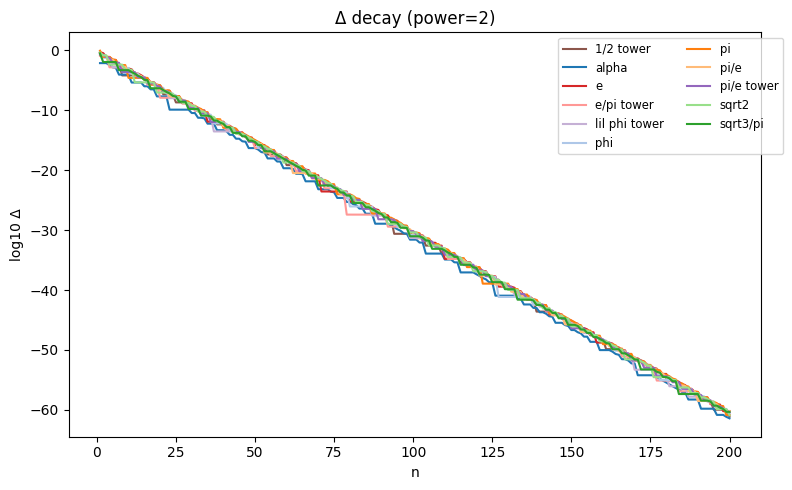

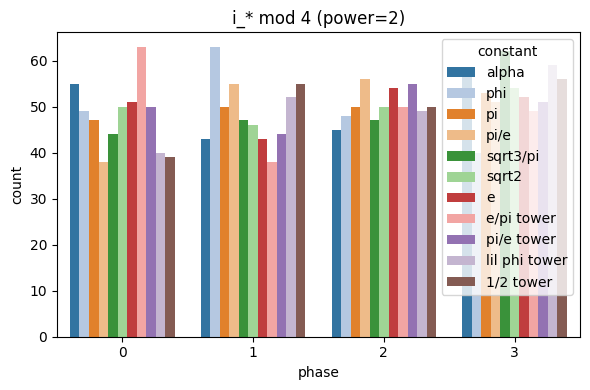

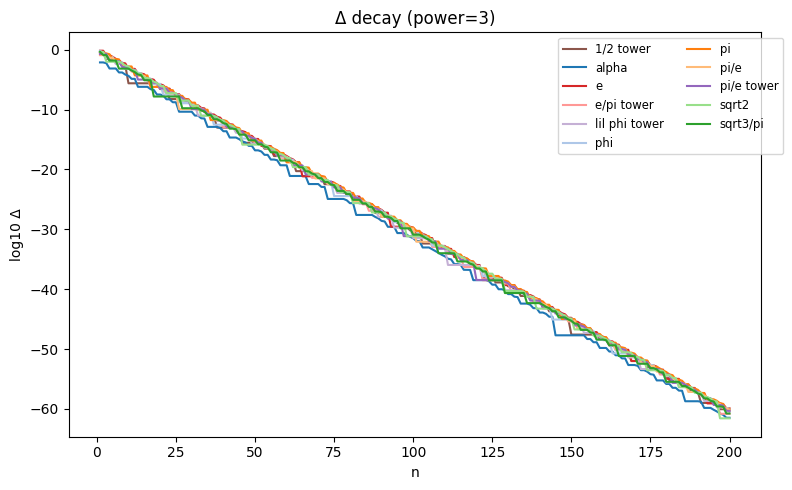

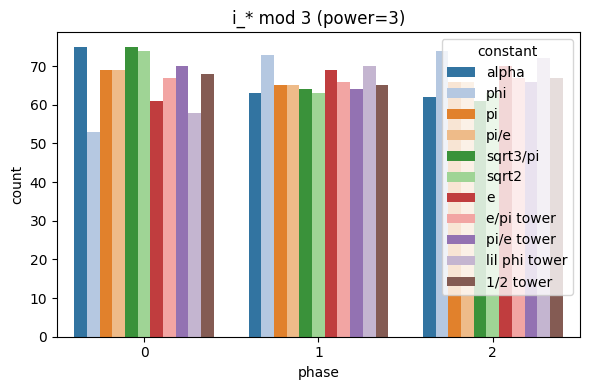

In [19]:
palette = sns.color_palette('tab20', n_colors=len(CONSTANTS))
const2color = dict(zip(CONSTANTS.keys(), palette))

for p in powers:
    subset = df[df['power']==p]
    # decay
    plt.figure(figsize=(8,5))
    for name, g in subset.groupby('constant'):
        plt.plot(g['n'], g['log10_delta'], label=name,
                 color=const2color[name])
    plt.xlabel('n'); plt.ylabel('log10 Δ')
    plt.title(f'Δ decay (power={p})')
    plt.legend(ncol=2, bbox_to_anchor=(1.04,1), fontsize='small')
    plt.tight_layout(); plt.show()

    # phase
    mod_val = p if p>2 else 4
    plt.figure(figsize=(6,4))
    sns.countplot(data=subset, x='phase', hue='constant',
                  palette=palette)
    plt.title(f'i_* mod {mod_val} (power={p})')
    plt.tight_layout(); plt.show()


In [20]:
print("=== Slope diagnostics ===")
for p in powers:
    subset = df[df['power']==p]
    print(f"\n-- power {p} --")
    for name, g in subset.groupby('constant'):
        slope, *_ , r, pval, _ = stats.linregress(g['n'], g['delta'].apply(lambda x: float(mp.log(x, 2))).values)
        print(f"{name:14s} slope={slope:7.3f} R²={r**2:6.6f} p={pval:.1e}")
print("\n=== κ plateau (median last 20 n) ===")
for p in powers:
    subset = df[df['power']==p]
    print(f"\n-- power {p} --")
    for name, g in subset.groupby('constant'):
        plateau = g[g['n']>n_max-20]['kappa_n'].apply(float).median()
        print(f"{name:14s} κ≈{plateau:.3e}")
print("\n=== Tie frequency (p=2) ===")
ties = df[df['power']==2].groupby('constant')['ties'].apply(lambda s: (s>1).mean())
print(ties.to_string())

=== Slope diagnostics ===

-- power 2 --
1/2 tower      slope= -1.000 R²=0.999505 p=0.0e+00
alpha          slope= -0.999 R²=0.999463 p=0.0e+00
e              slope= -0.999 R²=0.999383 p=9.9e-320
e/pi tower     slope= -0.997 R²=0.998825 p=4.9e-292
lil phi tower  slope= -1.001 R²=0.999427 p=5.9e-323
phi            slope= -1.003 R²=0.999238 p=1.2e-310
pi             slope= -0.999 R²=0.999437 p=9.9e-324
pi/e           slope= -1.001 R²=0.999661 p=0.0e+00
pi/e tower     slope= -0.999 R²=0.999675 p=0.0e+00
sqrt2          slope= -0.999 R²=0.999553 p=0.0e+00
sqrt3/pi       slope= -1.001 R²=0.999600 p=0.0e+00

-- power 3 --
1/2 tower      slope= -0.997 R²=0.999160 p=1.8e-306
alpha          slope= -1.001 R²=0.999292 p=8.1e-314
e              slope= -1.002 R²=0.999439 p=9.9e-324
e/pi tower     slope= -1.002 R²=0.999595 p=0.0e+00
lil phi tower  slope= -1.001 R²=0.999331 p=2.9e-316
phi            slope= -0.999 R²=0.999340 p=7.6e-317
pi             slope= -0.996 R²=0.999670 p=0.0e+00
pi/e           s